# Cooper 142 SNPs set (10 splits)


## Preparation

### Import required packages.

In [1]:
import matplotlib.pyplot as plt
import os, sys, warnings
import numpy as np
import pandas as pd
import statistics as st
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RepeatedKFold, StratifiedKFold
from sklearn.exceptions import ConvergenceWarning

### Read input matrix with genotypes

The matrix contains the genotypes from AMP-PD/MGRB dataset for 140 SNPs.

In [2]:
table = pd.read_csv("data/matrix.txt", sep="\t")
table

participant_id  phenotype      cohort gender inv_genotype  \
0     SY-NIH_INVAA791MKCET          1  STEADY-PD3      M           NI   
1     SY-NIH_INVEP886EEYYL          1  STEADY-PD3      M           NI   
2     SY-NIH_INVFM717GWDX4          1  STEADY-PD3      F           NI   
3     SY-NIH_INVNN611MKKN9          1  STEADY-PD3      M           NI   
4     SY-NIH_INVRB171EXGUK          1  STEADY-PD3      M           II   
...                    ...        ...         ...    ...          ...   
3107                 BABQX          0        MGRB      M           II   
3108                 BABRB          0        MGRB      F           II   
3109                 BABRE          0        MGRB      M           NI   
3110                 ZAAAB          0        MGRB      M           NI   
3111                 AABUO          0        MGRB      F           NN   

      rs2275579  rs144115304  rs115581042  rs79531911  rs138844738  ...  \
0             0            0            0           0            0  ...   
1             0            0            0           0            0  ...   
2             0            0            0           0            0  ...   
3             0            0            0           0            0  ...   
4             0            1            1           1            0  ...   
...         ...          ...          ...         ...          ...  ...   
3107          0            0            0           0            0  ...   
3108          0            0            0           0            0  ...   
3109          0            0            0           0            0  ...   
3110          0            0            0           0            0  ...   
3111          0            0            0           0            0  ...   

      rs10448130  rs34288580  rs34992950  rs7387252  rs2410595  rs41311559  \
0              2           2           1          2          1           0   
1              0           0           0          0          0           0   
2              0           0           0          0          0           0   
3              1           0           1          1          0           0   
4              1           1           0          1          0           0   
...          ...         ...         ...        ...        ...         ...   
3107           1           0           0          0          0           0   
3108           0           0           0          0          0           0   
3109           1           0           0          0          0           0   
3110           2           1           1          1          0           0   
3111           1           0           0          0          0           0   

      rs148894916  rs112957100  rs143756122  rs148514732  
0               0            0            0            0  
1               0            0            0            0  
2               0            0            0            0  
3               0            0            0            0  
4               0            0            0            0  
...           ...          ...          ...          ...  
3107            0            0            0            0  
3108            0            0            0            0  
3109            0            0            0            0  
3110            0            0            0            0  
3111            0            0            0            0  

[3112 rows x 145 columns]

### Distribution of data

#### Distribution by phenotype

(0=Control, 1=Case)

In [3]:
table.groupby('phenotype')['participant_id'].nunique()

phenotype
0    1556
1    1556
Name: participant_id, dtype: int64

#### Distribution by gender/phenotype

In [4]:
table.groupby(['gender', 'phenotype'])['participant_id'].nunique()

gender  phenotype
F       0            567
        1            567
M       0            989
        1            989
Name: participant_id, dtype: int64

#### Distribution by gender/phenotype/inv8_001 genotype

In [5]:
table.groupby(['gender', 'phenotype', 'inv_genotype'])['participant_id'].nunique()

gender  phenotype  inv_genotype
F       0          II              195
                   NI              259
                   NN              113
        1          II              175
                   NI              270
                   NN              122
M       0          II              318
                   NI              480
                   NN              191
        1          II              296
                   NI              477
                   NN              216
Name: participant_id, dtype: int64

## All participants

### Logistic regression model

In [6]:
pd.set_option('display.max_rows', 150)
X = table[table.columns[5:]]
y = table['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table.groupby('phenotype')['participant_id'].nunique()

phenotype
0    1556
1    1556
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [7]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#              'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#              'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.01, 0.02, 0.05],
              'max_iter': [10, 25, 50],
              'l1_ratio': [1, 0.9, 0.8]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.02, 0.05], 'l1_ratio': [1, 0.9, 0.8],
                         'max_iter': [10, 25, 50]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [8]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best AUC score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.5552

Non-zero coefficients: 2

Best estimator: LogisticRegression(C=0.02, l1_ratio=1, max_iter=25, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.02, 'l1_ratio': 1, 'max_iter': 25}
Best AUC score: 0.5492



SNP Coefficient
Index                        
1      rs11248057    0.055163
2       rs3806760    0.098122

### ROC with cross-validation

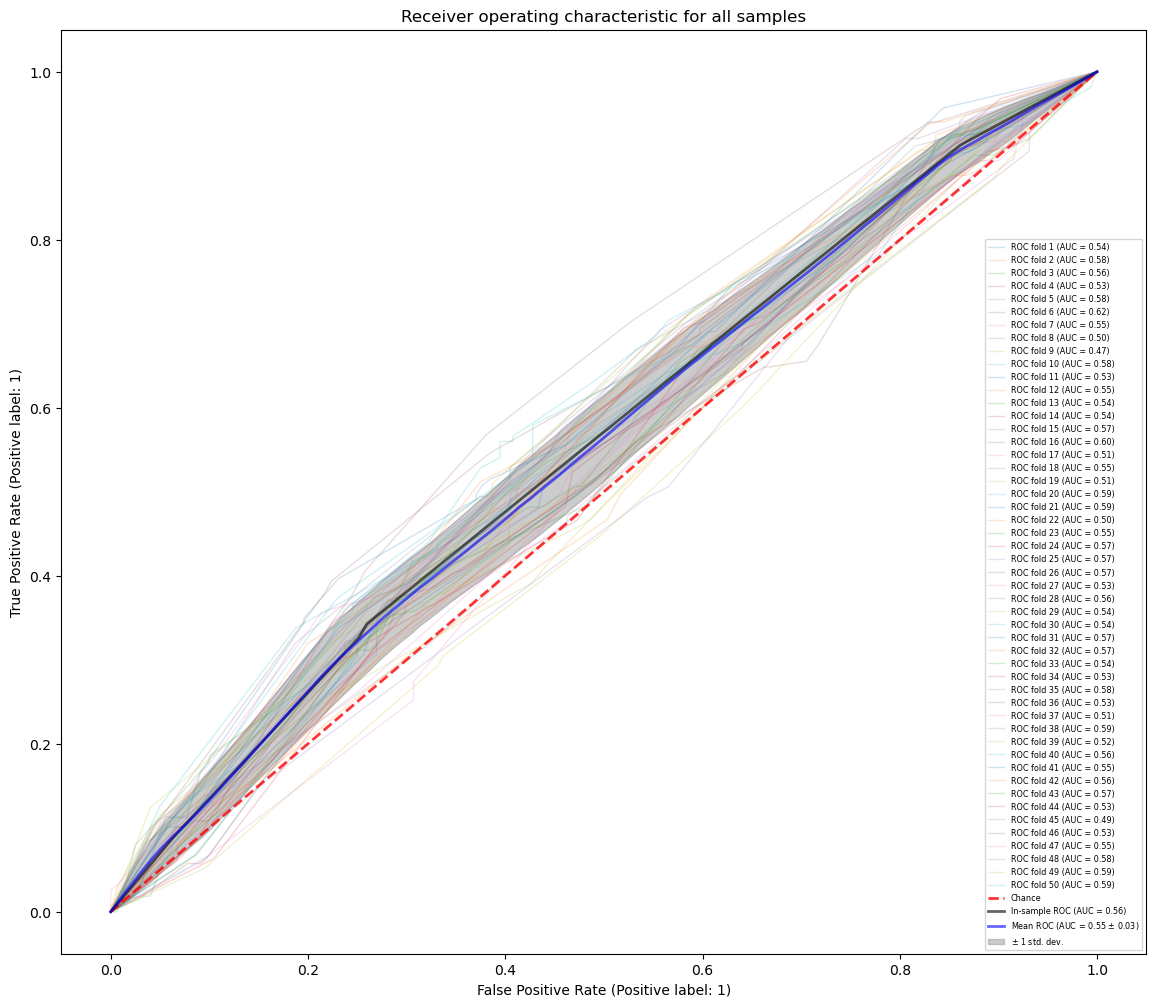

In [9]:
# Run classifier with cross-validation and plot ROC curves
name = "all"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## Males

### Logistic regression model

In [10]:
table1 = table[table.gender == "M"]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    989
1    989
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [11]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.01, 0.02],
              'max_iter': [75, 100, 150],
              'l1_ratio': [0.2, 0.1]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.02], 'l1_ratio': [0.2, 0.1],
                         'max_iter': [75, 100, 150]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [12]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.6243

Non-zero coefficients: 37

Best estimator: LogisticRegression(C=0.01, l1_ratio=0.1, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Best score: 0.5621



SNP Coefficient
Index                         
1        rs7520918    -0.10687
2      rs112270735   -0.077184
3         rs444618   -0.054004
4       rs13161496   -0.044109
5        rs3733349   -0.035941
6        rs3785891   -0.022054
7         rs494312   -0.015573
8       rs62190394   -0.008948
9       rs12995314    -0.00536
10      rs72838312   -0.004366
11     rs142448570    -0.00037
12      rs74609071    0.000361
13       rs4028634      0.0029
14      rs17016235     0.00292
15       rs1501467    0.006768
16       rs7682766    0.007628
17       rs6532190    0.010966
18        rs379066    0.015095
19       rs2412116    0.015274
20          rs5848    0.015471
21        rs764324     0.01817
22      rs11601088    0.019219
23      rs10110312    0.028269
24       rs4897753    0.029363
25       rs6599389     0.03295
26      rs11097213    0.036052
27       rs3822023    0.041542
28      rs79828056    0.046307
29       rs1372420    0.051416
30      rs11264302    0.057684
31      rs10831599    0.065901
32      rs12434297    0.068324
33       rs9985581    0.070506
34       rs6842271    0.077488
35      rs12935995    0.079672
36      rs11248057    0.080207
37       rs3806760    0.147021

### ROC with cross-validation

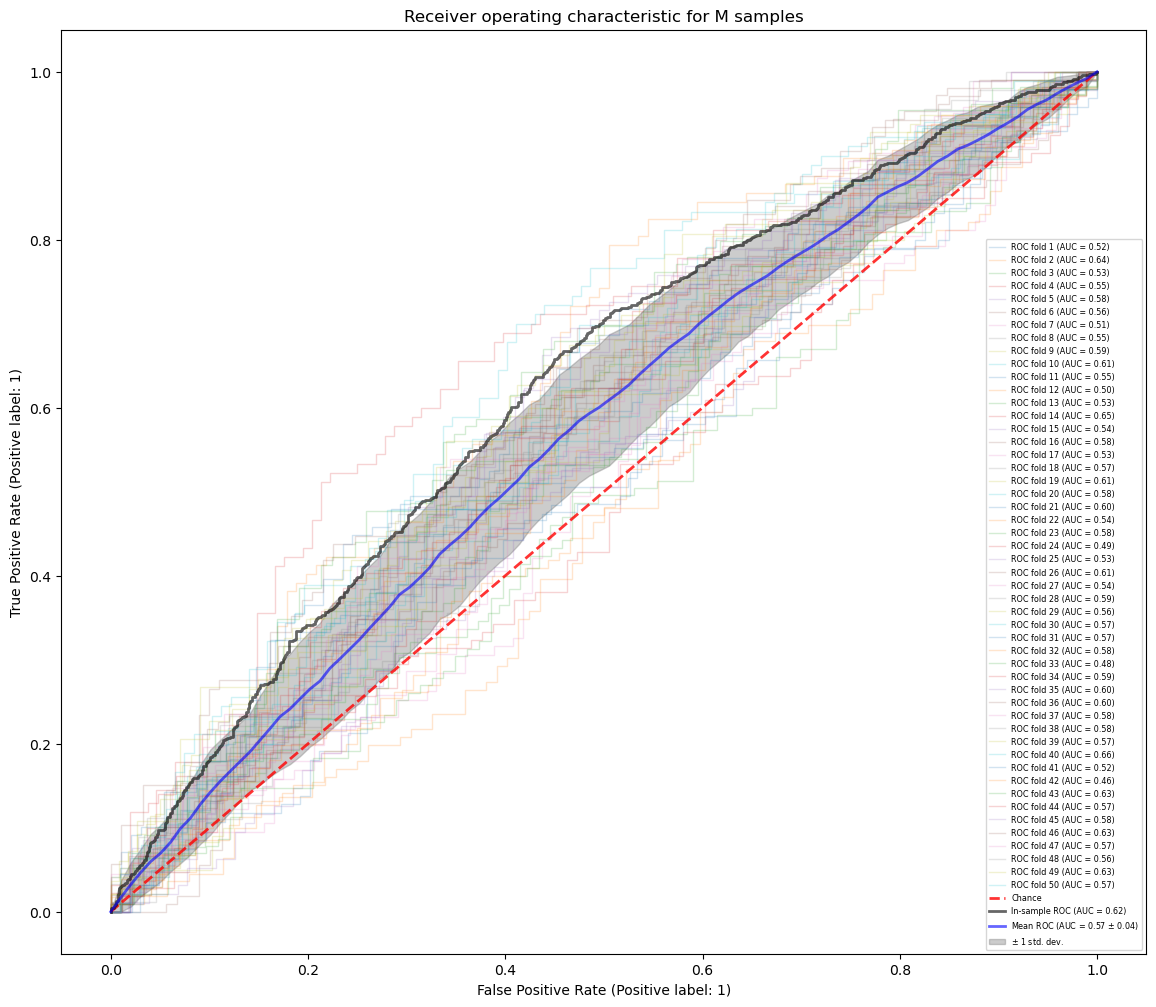

In [13]:
# Run classifier with cross-validation and plot ROC curves
name = "M"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## Females

### Logistic regression model

In [14]:
table1 = table[table.gender == "F"]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    567
1    567
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [15]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#              'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#              'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.005, 0.01],
              'max_iter': [25, 50, 75],
              'l1_ratio': [0.1, 0.2]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01], 'l1_ratio': [0.1, 0.2],
                         'max_iter': [25, 50, 75]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [16]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.5676

Non-zero coefficients: 6

Best estimator: LogisticRegression(C=0.005, l1_ratio=0.1, max_iter=50, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.005, 'l1_ratio': 0.1, 'max_iter': 50}
Best score: 0.5116



SNP Coefficient
Index                        
1       rs6871718   -0.026889
2       rs1949362   -0.023602
3          rs6964    0.005616
4      rs11248057    0.005966
5       rs3850379    0.008878
6       rs3806760    0.016905

### ROC with cross-validation

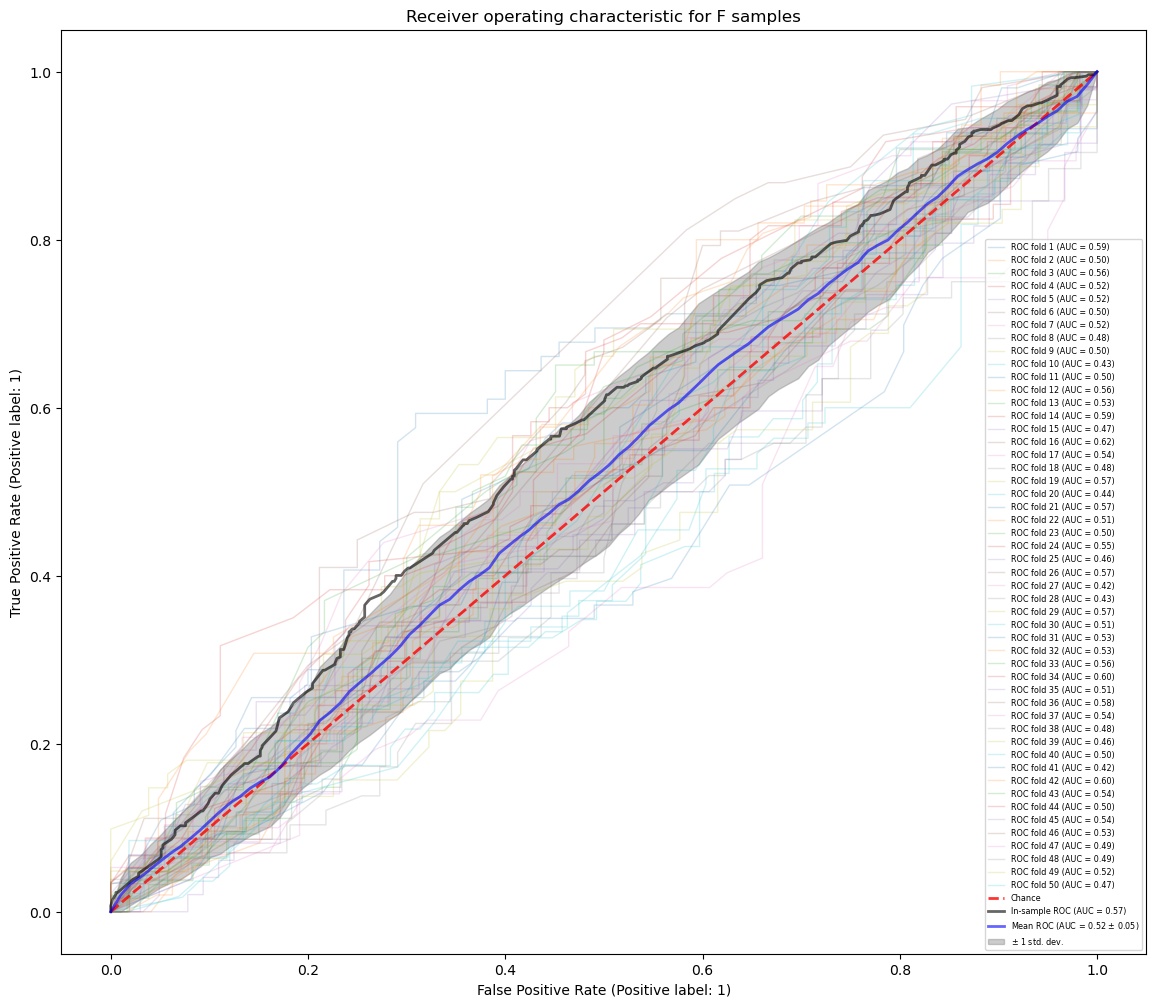

In [17]:
# Run classifier with cross-validation and plot ROC curves
name = "F"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## NN

### Logistic regression model

In [18]:
table1 = table[table.inv_genotype=="NN"]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    304
1    338
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [19]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#              'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#              'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.01, 0.02, 0.05],
              'max_iter': [10, 25],
              'l1_ratio': [0.5, 0.4, 0.3]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.02, 0.05], 'l1_ratio': [0.5, 0.4, 0.3],
                         'max_iter': [10, 25]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [20]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.6094

Non-zero coefficients: 9

Best estimator: LogisticRegression(C=0.02, l1_ratio=0.3, max_iter=10, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.02, 'l1_ratio': 0.3, 'max_iter': 10}
Best score: 0.5289



SNP Coefficient
Index                        
1       rs7826007   -0.013424
2       rs4897753    0.001234
3       rs3822023    0.005838
4       rs6842271    0.010758
5      rs12434297    0.012576
6          rs6964    0.014571
7       rs9985581    0.020144
8       rs3806760    0.031815
9      rs11248057    0.106701

### ROC with cross-validation

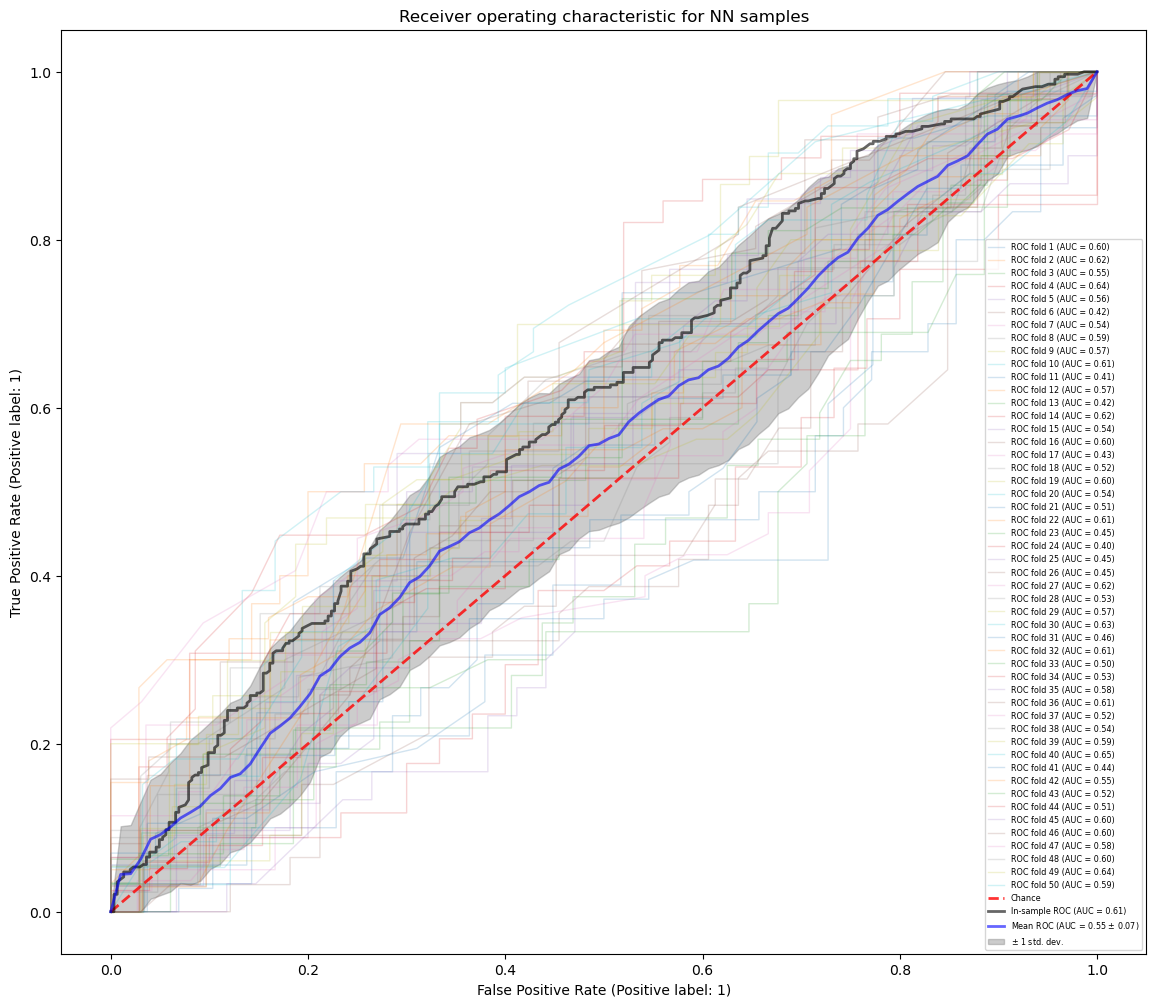

In [21]:
# Run classifier with cross-validation and plot ROC curves
name = "NN"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## NI

### Logistic regression model

In [22]:
table1 = table[table.inv_genotype=="NI"]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    739
1    747
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [23]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.005, 0.01],
              'max_iter': [10, 25, 50],
              'l1_ratio': [0.2, 0.1]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01], 'l1_ratio': [0.2, 0.1],
                         'max_iter': [10, 25, 50]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [24]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.5797

Non-zero coefficients: 8

Best estimator: LogisticRegression(C=0.01, l1_ratio=0.2, max_iter=10, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.01, 'l1_ratio': 0.2, 'max_iter': 10}
Best score: 0.5327



SNP Coefficient
Index                        
1       rs7520918   -0.045971
2       rs1949362   -0.017297
3       rs6532190    0.008321
4      rs17016235     0.00924
5       rs6842271    0.023003
6       rs9985581     0.03514
7       rs7682766    0.036363
8       rs3806760    0.047802

### ROC with cross-validation

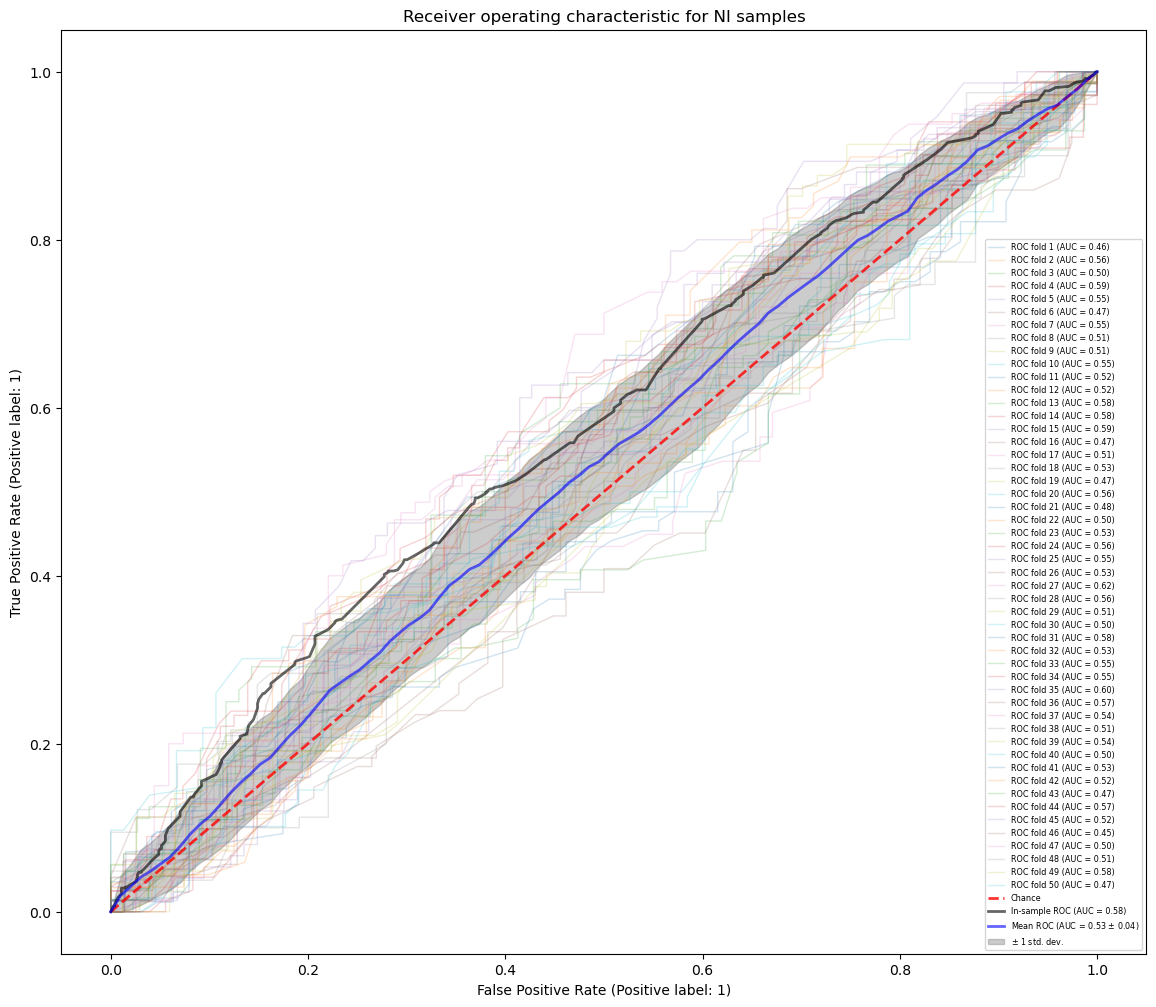

In [25]:
# Run classifier with cross-validation and plot ROC curves
name = "NI"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## II

### Logistic regression model

In [26]:
table1 = table[table.inv_genotype=="II"]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    513
1    471
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [27]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.005, 0.01, 0.02],
              'max_iter': [50, 100, 200],
              'l1_ratio': [0.2, 0.1]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01, 0.02], 'l1_ratio': [0.2, 0.1],
                         'max_iter': [50, 100, 200]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [28]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.6604

Non-zero coefficients: 26

Best estimator: LogisticRegression(C=0.01, l1_ratio=0.1, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Best score: 0.5940



SNP Coefficient
Index                         
1          rs34333   -0.057329
2         rs494312    -0.05673
3        rs3733349   -0.055571
4        rs6871718   -0.051304
5         rs444618   -0.032258
6        rs1736103   -0.031732
7        rs7535292   -0.026481
8       rs13161496   -0.016119
9        rs4331494   -0.004139
10      rs34992950   -0.003211
11      rs12510869   -0.000945
12       rs2412116    0.001716
13       rs2410595    0.003706
14       rs4859611    0.014846
15     rs112318363    0.015892
16        rs379066    0.019658
17      rs13188899    0.030844
18      rs12935995     0.03166
19        rs231454    0.036038
20       rs3822023    0.043356
21      rs11097213    0.059403
22      rs11248057    0.077958
23      rs12434297    0.094157
24      rs11264302    0.095165
25       rs3806760    0.114488
26          rs5848    0.126228

### ROC with cross-validation

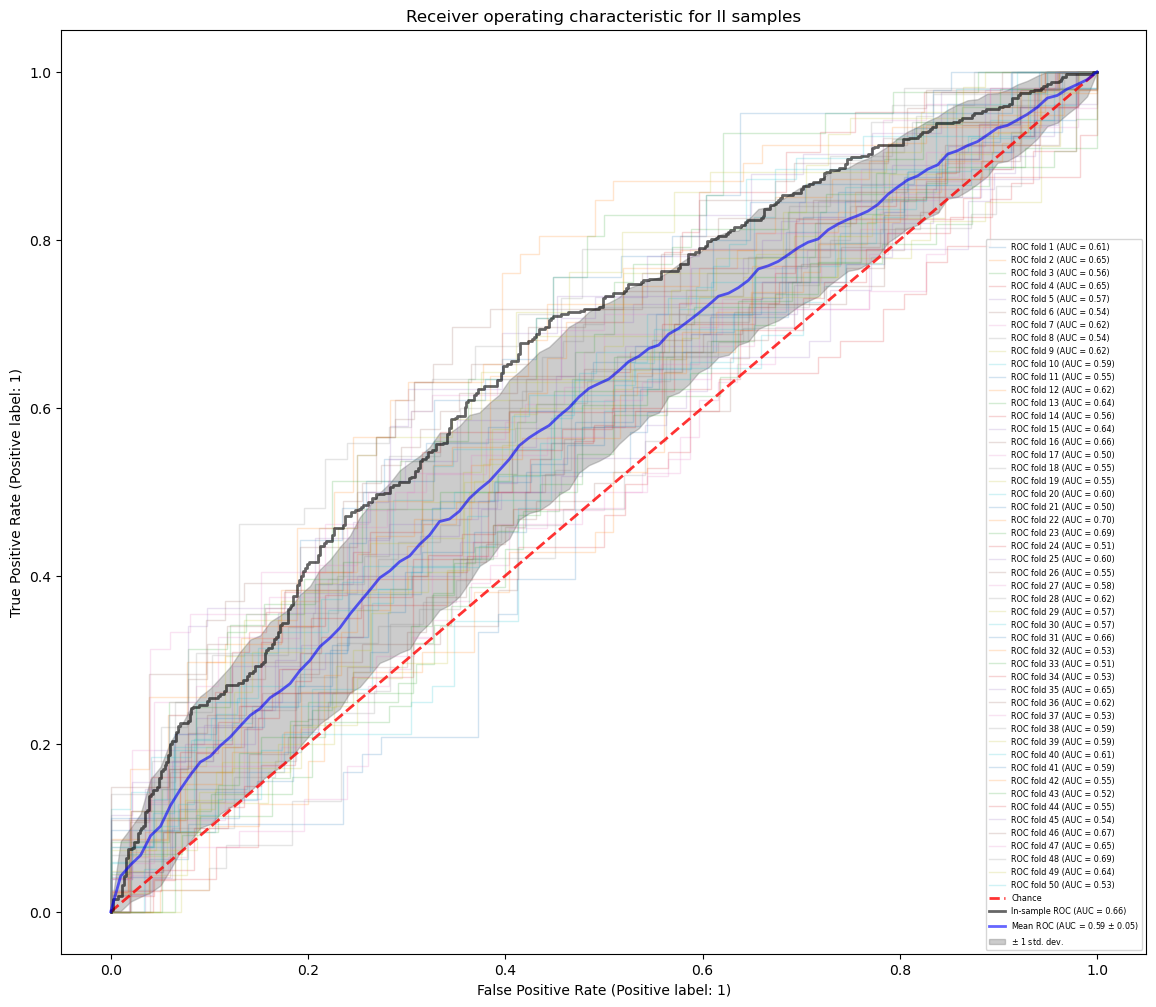

In [29]:
# Run classifier with cross-validation and plot ROC curves
name = "II"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## NN Males

### Logistic regression model

In [30]:
table1 = table[(table.gender == "M") & (table.inv_genotype=="NN")]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    191
1    216
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [31]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.05, 0.1, 0.5],
              'max_iter': [10, 25],
              'l1_ratio': [0.7, 0.6, 0.5]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 0.5], 'l1_ratio': [0.7, 0.6, 0.5],
                         'max_iter': [10, 25]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [32]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.7224

Non-zero coefficients: 32

Best estimator: LogisticRegression(C=0.1, l1_ratio=0.6, max_iter=10, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.1, 'l1_ratio': 0.6, 'max_iter': 10}
Best score: 0.5580



SNP Coefficient
Index                          
1        rs35776335   -0.213769
2        rs13161496   -0.193039
3        rs12499663   -0.150666
4          rs444618   -0.124434
5       rs112270735   -0.083023
6      rs1269243287   -0.055458
7         rs3912643   -0.048141
8        rs11097297   -0.047875
9         rs2128786    -0.03413
10        rs3850379   -0.030484
11        rs4331494   -0.014515
12       rs11264302   -0.001455
13        rs3850745   -0.001154
14       rs35456861   -0.000152
15         rs764324   -0.000024
16       rs12543164    0.000034
17       rs10448130    0.000146
18       rs35933728    0.000247
19        rs2412116    0.018849
20       rs79828056    0.022762
21        rs1949362    0.027434
22        rs1501467    0.035676
23       rs78197677     0.05128
24        rs1372420    0.073048
25        rs6842271    0.088079
26       rs12434297    0.089281
27        rs9985581    0.124415
28        rs3822023    0.128854
29       rs55805734    0.133538
30        rs4897753    0.210087
31           rs6964    0.215979
32        rs3806760    0.233441

### ROC with cross-validation

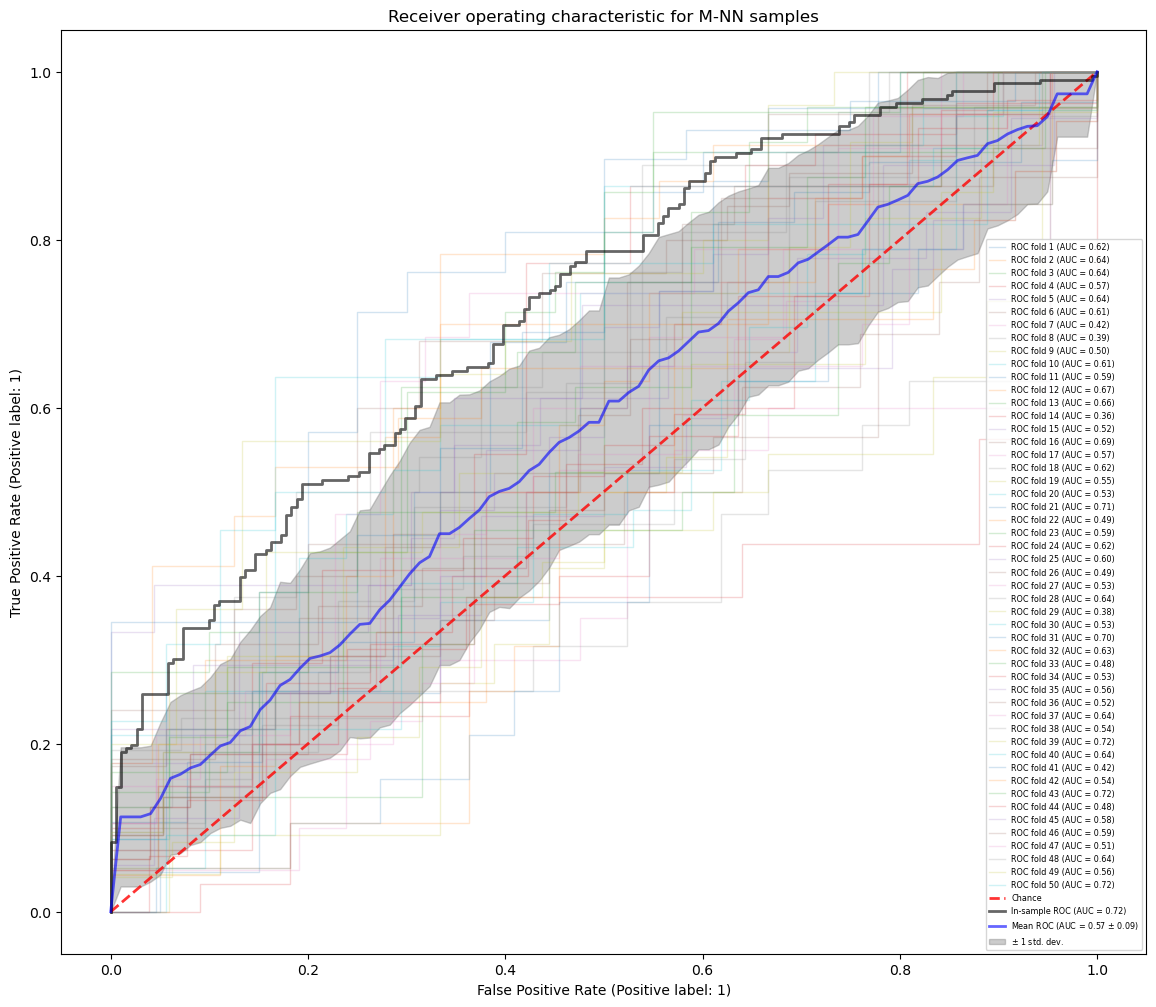

In [33]:
# Run classifier with cross-validation and plot ROC curves
name = "M-NN"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## NI Males

### Logistic regression model

In [34]:
table1 = table[(table.gender == "M") & (table.inv_genotype=="NI")]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    480
1    477
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [35]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.005, 0.01],
              'max_iter': [10, 25, 50],
              'l1_ratio': [0.2, 0.1]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01], 'l1_ratio': [0.2, 0.1],
                         'max_iter': [10, 25, 50]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [36]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.5836

Non-zero coefficients: 4

Best estimator: LogisticRegression(C=0.005, l1_ratio=0.1, max_iter=25, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.005, 'l1_ratio': 0.1, 'max_iter': 25}
Best score: 0.5213



SNP Coefficient
Index                       
1      rs7520918   -0.011899
2      rs9985581    0.016555
3      rs6842271    0.016555
4      rs3806760    0.027075

### ROC with cross-validation

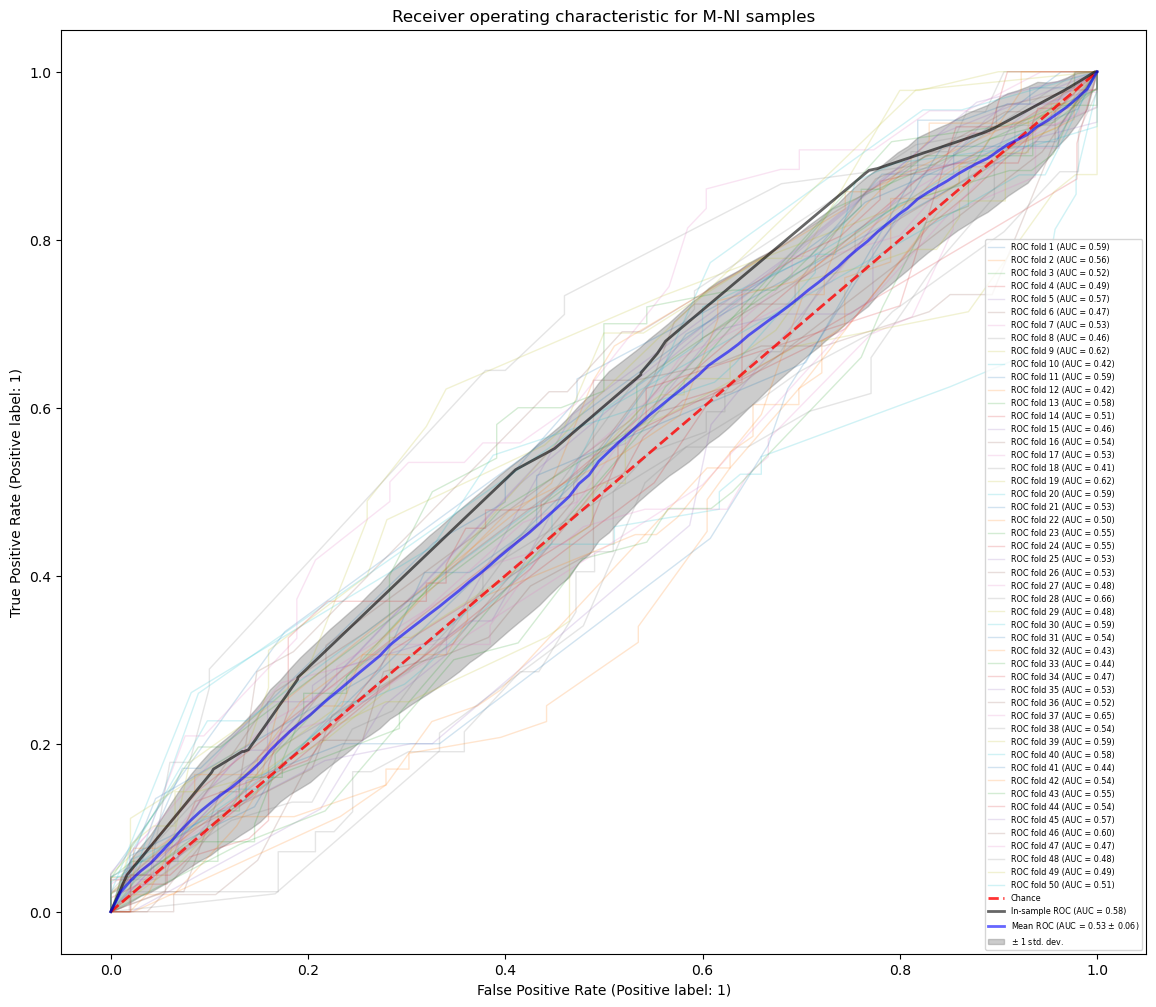

In [37]:
# Run classifier with cross-validation and plot ROC curves
name = "M-NI"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## II Males

### Logistic regression model

In [38]:
table1 = table[(table.gender == "M") & (table.inv_genotype=="II")]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    318
1    296
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [39]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.01, 0.02],
              'max_iter': [50, 75, 100],
              'l1_ratio': [0.2, 0.1]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.02], 'l1_ratio': [0.2, 0.1],
                         'max_iter': [50, 75, 100]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [40]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.6759

Non-zero coefficients: 18

Best estimator: LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=75, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 75}
Best score: 0.6007



SNP Coefficient
Index                         
1          rs34333   -0.092096
2        rs3733349   -0.053093
3        rs3785891   -0.013793
4        rs8064765   -0.003056
5       rs62075803   -0.002828
6        rs4796663   -0.002828
7        rs4028634    0.001729
8        rs2410595    0.003947
9         rs764324     0.00623
10       rs4482120    0.009129
11     rs112318363    0.037641
12      rs12935995    0.040157
13      rs11097213    0.049525
14       rs3806760    0.050662
15      rs11248057    0.078256
16      rs11264302     0.08048
17          rs5848    0.085027
18      rs12434297    0.085108

### ROC with cross-validation

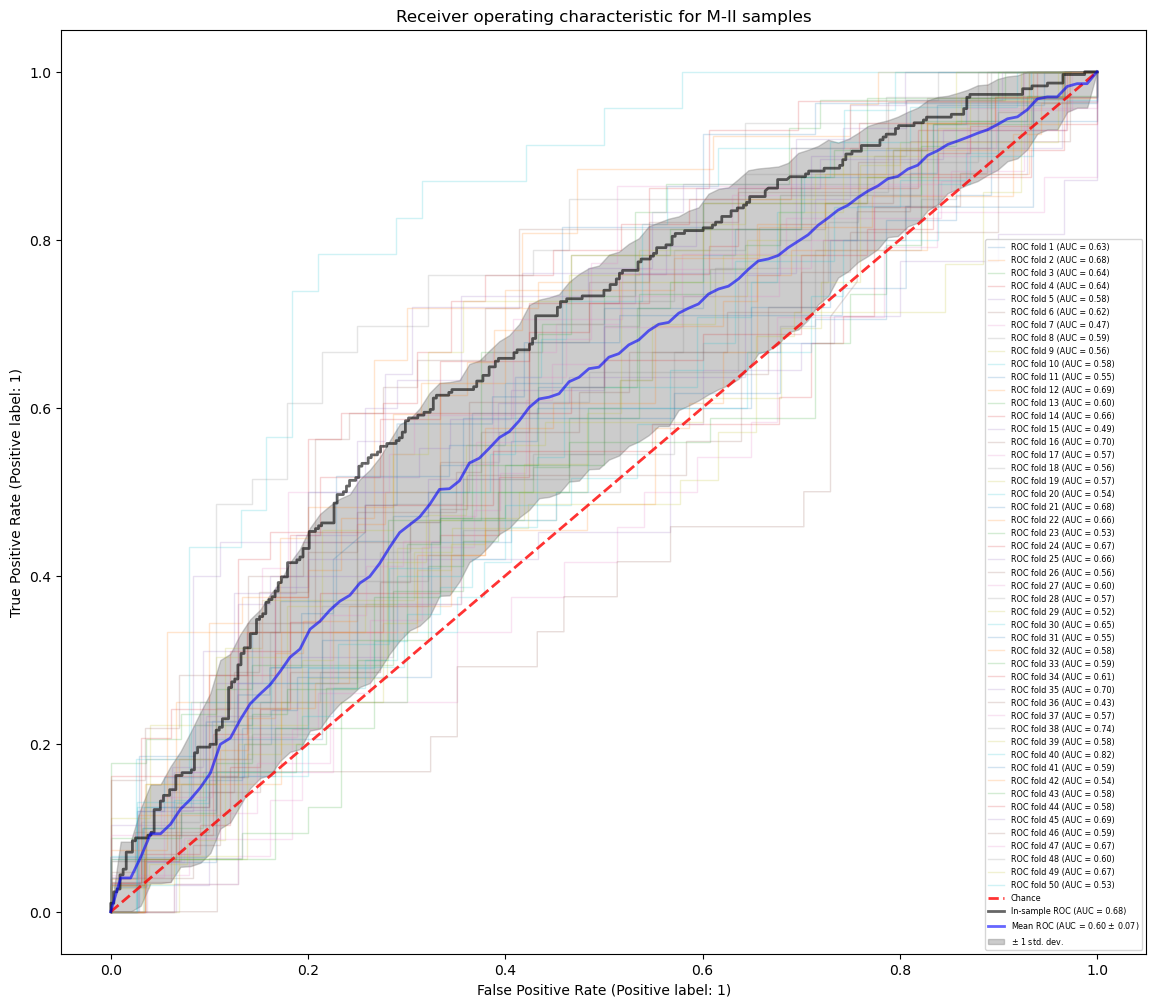

In [41]:
# Run classifier with cross-validation and plot ROC curves
name = "M-II"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## NN Females

### Logistic regression model

In [42]:
table1 = table[(table.gender == "F") & (table.inv_genotype=="NN")]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    113
1    122
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [43]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.1, 0.5, 1],
              'max_iter': [10, 25],
              'l1_ratio': [0.7, 0.6, 0.5]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'l1_ratio': [0.7, 0.6, 0.5],
                         'max_iter': [10, 25]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [44]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.8582

Non-zero coefficients: 112

Best estimator: LogisticRegression(C=0.5, l1_ratio=0.6, max_iter=10, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.5, 'l1_ratio': 0.6, 'max_iter': 10}
Best score: 0.5680



SNP Coefficient
Index                          
1         rs6871718   -0.426813
2          rs999361   -0.426221
3         rs7826007   -0.365302
4         rs3733349   -0.346928
5        rs78197677   -0.284285
6         rs7535292    -0.26294
7         rs4859611   -0.257429
8         rs1949362   -0.254682
9        rs11601088   -0.247447
10        rs7515378   -0.221912
11       rs12101192   -0.193561
12         rs231454   -0.182738
13        rs1859223   -0.170208
14       rs79976845   -0.159289
15        rs4495967   -0.150381
16        rs4482120   -0.150381
17        rs1501467   -0.140416
18       rs79828056   -0.136308
19        rs2433733    -0.12592
20        rs1372420   -0.125209
21       rs41311559   -0.114078
22      rs140859835   -0.084564
23       rs11097297   -0.083788
24       rs11097213   -0.076345
25        rs3822023   -0.074309
26      rs142448570   -0.073881
27       rs10448130   -0.073017
28       rs76848738   -0.061152
29       rs11021711   -0.060124
30       rs28691231   -0.049795
31     rs1269243287   -0.049795
32       rs34572188   -0.049509
33        rs2412116   -0.043475
34         rs375017    -0.03843
35        rs7666159   -0.033879
36        rs4416502   -0.030128
37        rs9330264   -0.027804
38         rs734073   -0.023279
39       rs55805734   -0.021777
40        rs8064765   -0.019273
41        rs4796663   -0.015331
42       rs62075803   -0.015331
43       rs12510869   -0.009278
44        rs3850379   -0.000811
45       rs10515816   -0.000433
46        rs3912643   -0.000415
47       rs13188899    -0.00041
48        rs4921799   -0.000409
49        rs4897753   -0.000298
50           rs6964   -0.000209
51        rs3806760   -0.000191
52        rs4028634   -0.000161
53       rs11579790   -0.000147
54         rs379066   -0.000132
55        rs3850745   -0.000123
56        rs4841589   -0.000072
57       rs12499663   -0.000069
58       rs74609071    0.000652
59       rs35456861    0.001887
60        rs9985581    0.009368
61        rs6842271    0.009368
62       rs34288580    0.009444
63      rs148514732    0.012629
64        rs7515370    0.020841
65           rs5848    0.023656
66       rs77312060    0.026649
67       rs72838312     0.02777
68         rs444618    0.029691
69       rs12995314    0.031652
70       rs62190394    0.031652
71       rs10110312    0.033873
72       rs12543164    0.035274
73        rs2075583    0.035907
74        rs6532190    0.039457
75       rs17324625    0.051377
76        rs7682766    0.058691
77      rs143756122    0.060175
78      rs148894916    0.060175
79       rs11264302    0.060206
80       rs71371995    0.061233
81       rs12150561    0.063362
82         rs494312    0.066012
83      rs536718528    0.066406
84       rs12935995    0.070272
85        rs2410595    0.070705
86        rs7104332    0.077242
87        rs4331494    0.077355
88        rs7734182    0.085825
89       rs35933728    0.086571
90       rs17016235    0.090649
91          rs34333    0.112067
92      rs201304809    0.120855
93       rs12434297    0.130994
94       rs11589479    0.132404
95        rs9799610    0.162529
96       rs72803476    0.163414
97       rs35776335    0.173641
98        rs2128786    0.189926
99       rs72846765    0.194033
100       rs6599389    0.196567
101      rs73211813    0.203329
102       rs7387252     0.20655
103       rs1800606     0.21257
104        rs208024    0.219757
105       rs9971953    0.254225
106       rs9971789    0.254225
107       rs7520918    0.289942
108      rs13161496    0.291558
109       rs3785891    0.302039
110        rs764324    0.306943
111       rs4241591    0.308725
112      rs11248057     0.32366

### ROC with cross-validation

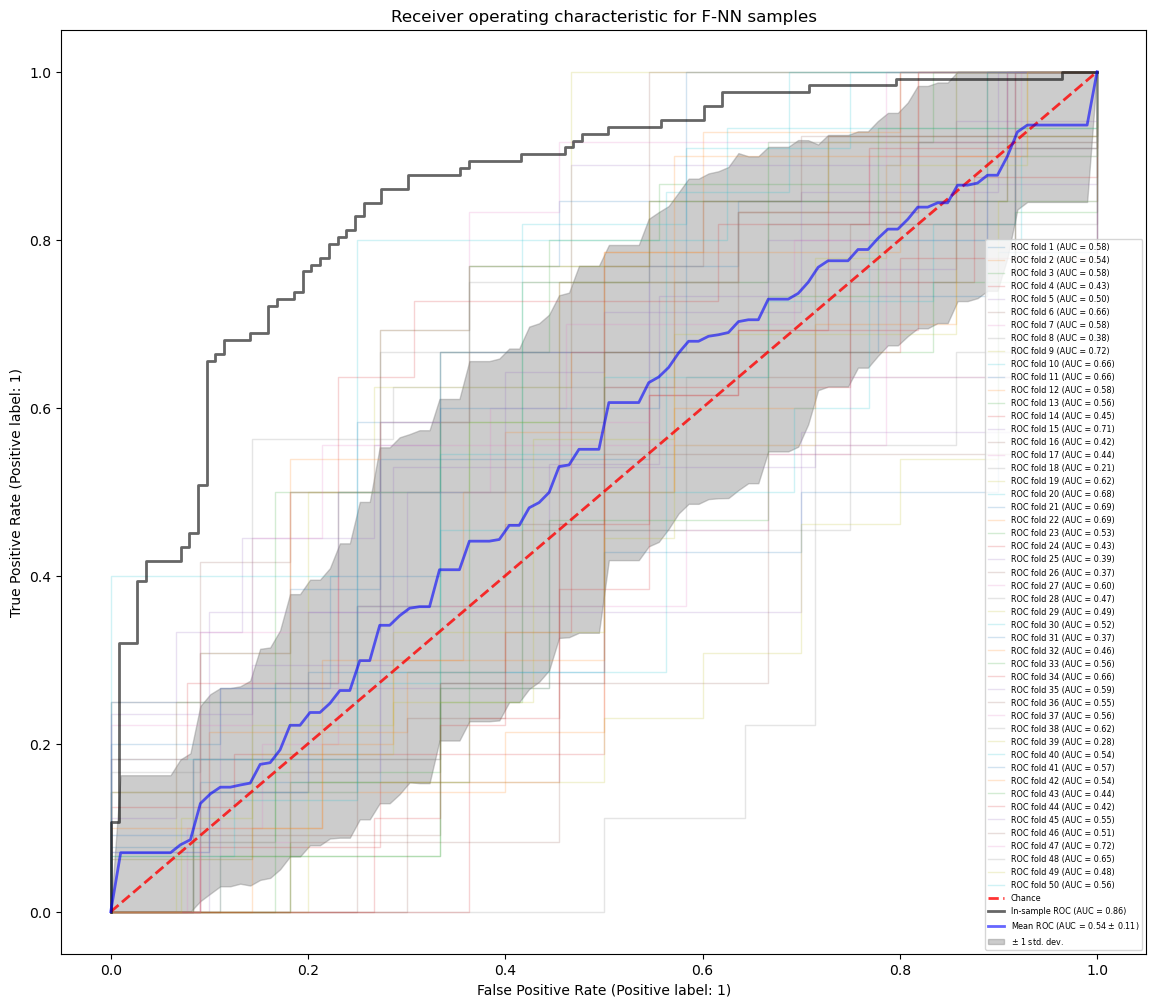

In [45]:
# Run classifier with cross-validation and plot ROC curves
name = "F-NN"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## NI Females

### Logistic regression model

In [46]:
table1 = table[(table.gender == "F") & (table.inv_genotype=="NI")]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    259
1    270
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [47]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#              'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#              'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [0.005, 0.01],
              'max_iter': [10, 25],
              'l1_ratio': [1, 0.9]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01], 'l1_ratio': [1, 0.9],
                         'max_iter': [10, 25]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [48]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.5000

Non-zero coefficients: 0

Best estimator: LogisticRegression(C=0.005, l1_ratio=1, max_iter=10, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 0.005, 'l1_ratio': 1, 'max_iter': 10}
Best score: 0.5000



Empty DataFrame
Columns: [SNP, Coefficient]
Index: []

### ROC with cross-validation

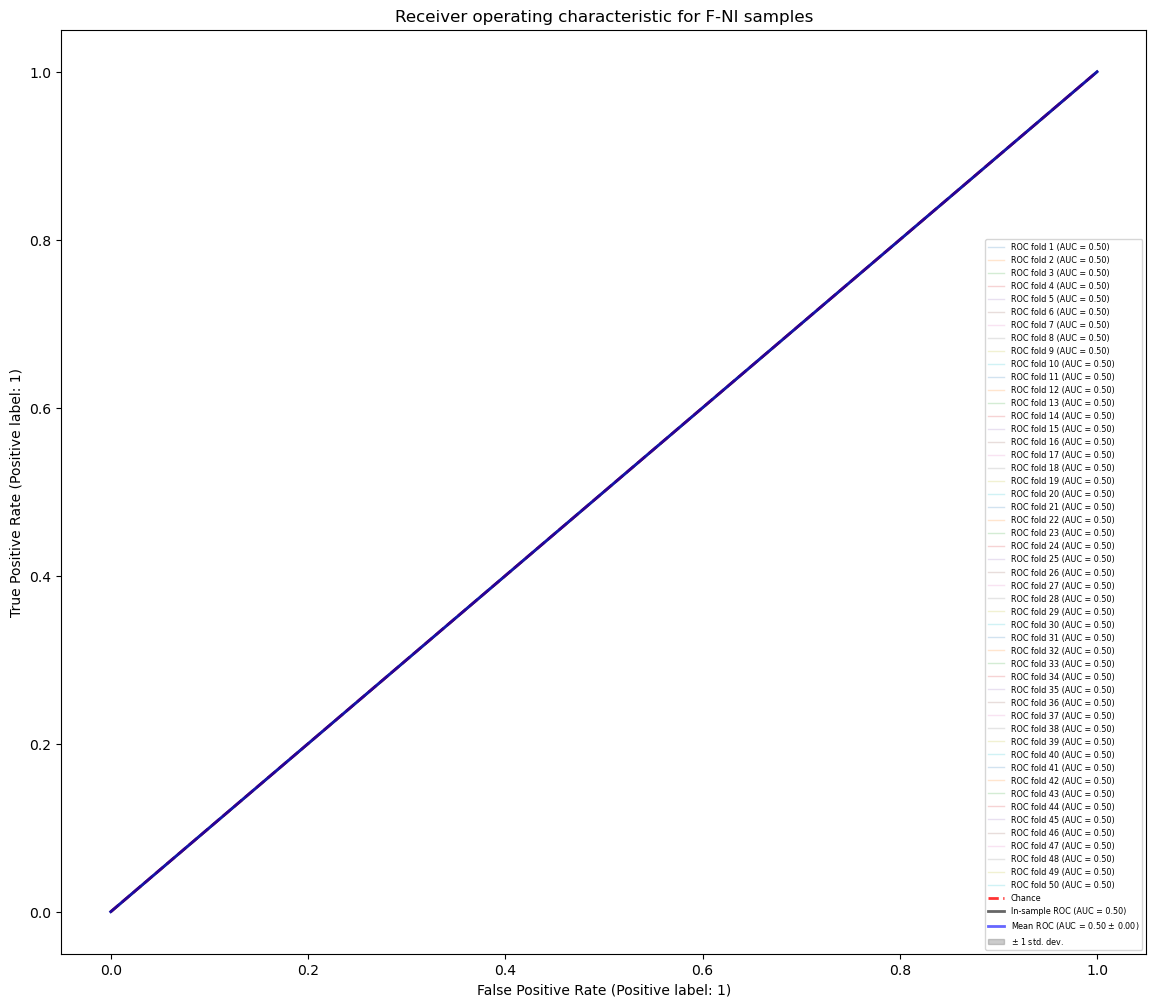

In [49]:
# Run classifier with cross-validation and plot ROC curves
name = "F-NI"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()

## II Females

### Logistic regression model

In [50]:
table1 = table[(table.gender == "F") & (table.inv_genotype=="II")]
X = table1[table1.columns[5:]]
y = table1['phenotype']
lr = LogisticRegression(random_state=42, solver='saga', n_jobs=-1, penalty='elasticnet')
table1.groupby('phenotype')['participant_id'].nunique()

phenotype
0    195
1    175
Name: participant_id, dtype: int64

### Grid search for 3 hyperparameters

In [51]:
# parameters = {'C': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 10, 20, 30],
#               'max_iter': [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600],
#               'l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}

parameters = {'C': [1, 10, 20],
              'max_iter': [1600, 3200],
              'l1_ratio': [1, 0.9]}

grid_lr = GridSearchCV(lr, parameters, verbose=False, scoring='roc_auc', n_jobs=-1, cv=10)
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
grid_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [1, 10, 20], 'l1_ratio': [1, 0.9],
                         'max_iter': [1600, 3200]},
             scoring='roc_auc', verbose=False)

### Best estimator

In [52]:
best_lr = grid_lr.best_estimator_

max_auc_score = roc_auc_score(y, best_lr.predict_proba(X)[:, 1])
coefs = best_lr.coef_[0, :]
num_coef = np.sum(coefs != 0)
X_header = np.array(X.columns)

data_array = np.vstack((X_header, coefs))
model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
print(f'Max AUC score:{max_auc_score:.4f}\n')
print(f'Non-zero coefficients: {num_coef}\n')
print(f'Best estimator: {grid_lr.best_estimator_}')
print(f'Scorer: {grid_lr.scorer_}')
print(f'Best params: {grid_lr.best_params_}')
print(f'Best score: {grid_lr.best_score_:.4f}\n')
m = model_coefs[model_coefs['Coefficient'] != 0 ].sort_values(by='Coefficient')
m = m.reset_index(drop=True).assign(Index=range(len(m)))
m.Index= m.Index + 1
m.set_index('Index')

Max AUC score:0.8848

Non-zero coefficients: 131

Best estimator: LogisticRegression(C=10, l1_ratio=1, max_iter=3200, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')
Scorer: make_scorer(roc_auc_score, needs_threshold=True)
Best params: {'C': 10, 'l1_ratio': 1, 'max_iter': 3200}
Best score: 0.5429



SNP Coefficient
Index                          
1       rs138844738   -4.155261
2       rs115879964   -4.155261
3       rs536718528   -3.617586
4       rs115448944   -3.150895
5        rs71607338    -2.57904
6        rs17324625   -2.427067
7         rs2433733   -1.988805
8         rs6842271   -1.715214
9        rs62075803   -1.652955
10        rs4796663   -1.652955
11      rs112957100   -1.549041
12       rs79976845   -1.439649
13       rs74950708   -1.321806
14       rs11021711   -1.198849
15        rs1065712   -1.095391
16         rs444618   -1.090401
17       rs13131187   -1.017069
18         rs375017   -1.003348
19       rs11248057   -0.968769
20         rs494312   -0.932152
21        rs3733349   -0.883251
22      rs140859835   -0.836965
23        rs7535292   -0.718728
24        rs7515378   -0.699743
25         rs734073   -0.657171
26       rs76848738   -0.613196
27        rs4482120   -0.610804
28        rs6871718   -0.604013
29      rs112318363   -0.522652
30       rs74609071   -0.505636
31       rs12499663   -0.467277
32       rs77312060   -0.455806
33        rs3744427   -0.437119
34       rs12434297   -0.431097
35       rs11589479   -0.430368
36        rs7666159   -0.427637
37          rs34333   -0.413831
38       rs10110312   -0.399533
39        rs4921799   -0.395144
40        rs1372420   -0.388175
41       rs10515816   -0.384538
42        rs1736103   -0.381249
43       rs73211813   -0.354654
44       rs10448130    -0.33797
45         rs764324   -0.313281
46        rs4841589   -0.298304
47         rs999361   -0.278567
48        rs7387252   -0.254134
49       rs72846765   -0.253638
50       rs71371995   -0.187556
51       rs34992950   -0.183292
52       rs11579790   -0.141663
53        rs9971953   -0.140982
54        rs9971789   -0.140982
55        rs7520918   -0.132976
56       rs35933728   -0.128462
57       rs13161496   -0.126504
58       rs28691231   -0.113809
59        rs4859611   -0.081506
60         rs379066   -0.054031
61       rs72803476   -0.048141
62        rs7826007   -0.021814
63       rs35456861    -0.01947
64      rs148514732   -0.010154
65        rs9330264   -0.008158
66       rs72838312   -0.000916
67       rs12543164    0.007514
68        rs1501467    0.008177
69      rs150107452    0.029482
70        rs4241591    0.036761
71     rs1269243287    0.044491
72        rs2128786    0.051102
73        rs2075583    0.066752
74        rs3785891    0.091773
75       rs12995314    0.108912
76       rs62190394    0.108912
77        rs1949362    0.110172
78        rs7682766    0.120521
79        rs6532182     0.12645
80        rs4331494    0.140858
81       rs12935995    0.148705
82        rs1859223    0.150722
83        rs7104332    0.155063
84        rs3850745    0.219926
85       rs11097213    0.221927
86      rs117979807    0.232891
87        rs2410595      0.2445
88       rs35776335    0.287265
89       rs12101192    0.326314
90        rs4495967    0.341328
91       rs79828056    0.353429
92       rs11264302    0.368833
93       rs17016235    0.383153
94        rs6532190    0.383153
95       rs34572188    0.393827
96         rs208024    0.402916
97       rs13188899    0.430538
98           rs6964    0.445559
99       rs75214905    0.458369
100       rs3822023    0.458818
101        rs231454    0.496512
102       rs4897753    0.501664
103      rs11097297    0.514293
104     rs148894916    0.565314
105     rs143756122    0.565314
106     rs201304809    0.586162
107      rs10831599    0.612322
108       rs7515370    0.632874
109       rs9799610    0.642287
110       rs2412116    0.660505
111     rs112270735    0.673886
112      rs12150561     0.82272
113       rs7734182    0.898797
114       rs6836715    0.936025
115      rs78197677    0.968978
116       rs6599389    1.057432
117      rs34288580    1.086857
118          rs5848     1.09313
119       rs3806760    1.103029
120     rs142448570    1.167941
121      rs41311559    1.289618
122       rs9985581    1.394087
123       rs3850379    1.404536
124      rs55805

### ROC with cross-validation

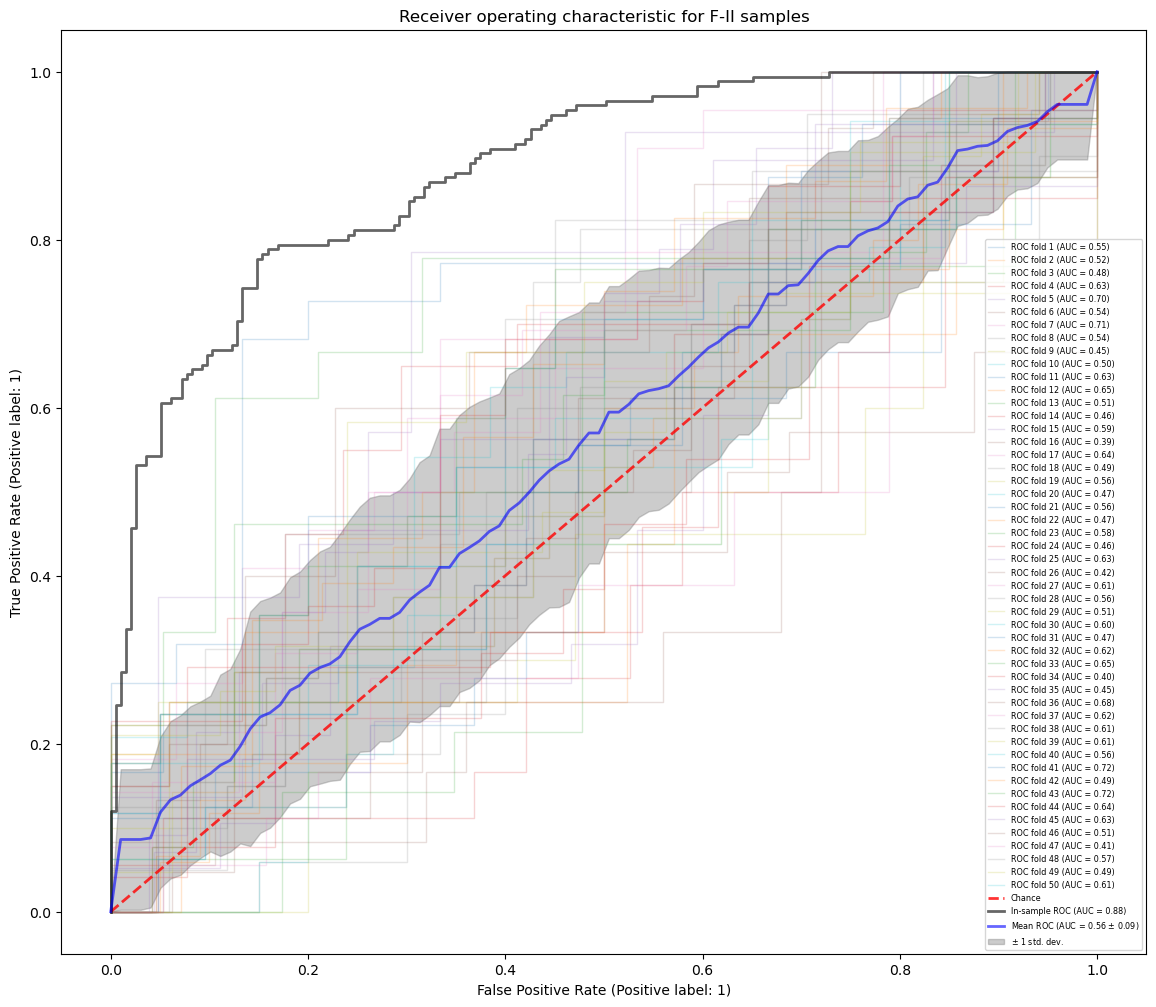

In [53]:
# Run classifier with cross-validation and plot ROC curves
name = "F-II"
bp = grid_lr.best_params_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
classifier = LogisticRegression(C=bp['C'], max_iter=bp['max_iter'], l1_ratio=bp['l1_ratio'], random_state=42,
      solver='saga', n_jobs=-1, penalty='elasticnet')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train,], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test,],
        y.iloc[test],
        name=f"ROC fold {i + 1}",
        alpha=0.2,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    X_header = np.array(X.columns)
    data_array = np.vstack((X_header, classifier.coef_[0,:]))
    model_coefs = pd.DataFrame(data=data_array.T, columns=['SNP', 'Coefficient'])
    m_name = f'data/{name}_10fold_repeat{i+1:02}_coefficients.txt'
    model_coefs.to_csv(m_name, sep='\t',index=False)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

classifier.fit(X, y)
viz = RocCurveDisplay.from_estimator(
    classifier,
    X,
    y,
    name=f"In-sample ROC",
    alpha=0.6,
    color="k",
    lw=2,
    ax=ax,
)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.6,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.4,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic for {name} samples",
)
ax.legend(loc="lower right", fontsize='xx-small'
)
plt.show()